# Projet 6 : Classifiez automatiquement des biens de consommation.

## Prétraitement, feature extraction et faisabilité

* [1. Contexte](#partie1)
* [2. Préparation de l'environnement](#partie2)
    * [2.1 Préparation des données](#partie2.1)
    * [2.1 Répertoire des fonctions](#partie2.1)
* [3. Premières observations](#partie3)
* [4. Exploration des données](#partie4)
* [5. Prétraitement des données textuelles](#partie5)
    * [5.1 Nettoyage des données](#partie5.1)
    * [5.2 Données textuelles : description](#partie5.2)
      * [5.2.1 CountVectorizer](#partie5.2.1)
      * [5.2.2 TF-IDF](#partie5.2.2)
    * [5.3 Données textuelles : product_name + description](#partie5.3)
      * [5.3.1 CountVectorizer](#partie5.3.1)
      * [5.3.2 TF-IDF](#partie5.3.2)
    * [5.4 Résultats](#partie5.4)
    * [5.5 LDA](#partie5.5)
* [6. Conclusion](#partie6)

## <font color='red'>1. Contexte</font><a class="anchor" id="partie1"></a>

Dans le cadre de ce projet, l'objectif est de vérifier la faisabilité de classer automatiquement des produits en utilisant des techniques d'analyse textuelle. L'idée est de pouvoir prédire les catégories de produits uniquement à partir des descriptions textuelles fournies. L'analyse se concentre sur la représentation en 2D des produits et l'évaluation de leur séparation automatique en fonction des catégories réelles sans passer par une classification supervisée.

Pour cela, plusieurs étapes sont envisagées :

- Prétraitement des données textuelles : Nettoyage, lemmatisation et tokenisation des descriptions de produits pour obtenir des données prêtes pour l'analyse.
- Extraction des features : Utilisation de méthodes comme Bag of Words et TF-IDF pour transformer les descriptions en vecteurs numériques.
Réduction de dimension : Application d'algorithmes comme l'ACP et le T-SNE pour réduire la dimension des données et permettre leur visualisation.
- Clustering : Application de l'algorithme K-Means pour regrouper les produits en clusters et vérification de la qualité des regroupements à l'aide de l'Adjusted Rand Index (ARI).
- Thématisation des clusters : Utilisation de LDA (Latent Dirichlet Allocation) pour identifier des thèmes dominants dans les descriptions de produits et analyser leur relation avec les catégories prédéfinies.

L'objectif principal est d'évaluer la faisabilité d'une séparation automatique des produits par catégorie, et de démontrer que les méthodes de transformation textuelle et de clustering permettent de regrouper efficacement les produits similaires.



## <font color='red'>2. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

### <font color='blue'>2.1 Préparation des données</font><a class="anchor" id="partie2.1">

In [ ]:
!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns
import ast
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
# Télécharger les stopwords et lemmatizer de NLTK
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger le fichier CSV dans un data frame
df = pd.read_csv('/content/drive/My Drive/projet_6/flipkart_com-ecommerce_sample_1050.csv')

### <font color='blue'>2.2 Répertoire des fonctions</font><a class="anchor" id="partie2.2">

In [ ]:
def plot_pie_chart(df, column, title="Pie Chart"):
    """
    Affiche un pie chart pour la colonne donnée.

    Args:
        df (DataFrame): DataFrame contenant les données.
        column (str): Nom de la colonne à visualiser sous forme de pie chart.
        title (str): Titre du graphique.
    """
    # Compter les occurrences des valeurs uniques dans la colonne
    data = df[column].value_counts()

    # Créer un pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [ ]:
def plot_bar_chart(df, column, title="Bar Plot", xlabel="Catégories", ylabel="Nombre"):
    """
    Affiche un bar plot pour la colonne donnée.

    Args:
        df (DataFrame): DataFrame contenant les données.
        column (str): Nom de la colonne à visualiser sous forme de bar plot.
        title (str): Titre du graphique.
        xlabel (str): Label de l'axe des X.
        ylabel (str): Label de l'axe des Y.
    """
    # Compter les occurrences des valeurs uniques dans la colonne et convertir en DataFrame
    data = df[column].value_counts().reset_index()
    data.columns = ['category', 'count']  # Renommer les colonnes pour une meilleure clarté

    # Créer un bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='category', y='count', data=data, hue='category', dodge=False, palette='Paired', legend=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
# Fonction pour séparer les catégories et sous-catégories
def split_categories(categories):
    """Sépare les catégories et sous-catégories à partir d'une chaîne formatée."""
    categories = categories.replace('["', "").replace('"]', "")
    cat_list = categories.split(' >> ')

    # Créer une série pour stocker les niveaux de catégories
    cat = pd.Series(dtype='object')

    # Remplir la série avec chaque niveau de catégorie
    for i in range(len(cat_list)):
        cat[f"cat_{i+1}"] = cat_list[i]

    return cat

In [ ]:
# Fonction pour nettoyer le texte sans lemmatisation (Bag-of-Words simple)
def transform_bow(text, stop_words):
    """Nettoie le texte en supprimant les stopwords, sans lemmatisation."""
    tokens = word_tokenize(text.lower())
    tokens_clean = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens_clean)


# Fonction pour nettoyer le texte avec lemmatisation
def transform_bow_lem(text, stop_words):
    """Nettoie le texte en supprimant les stopwords avec lemmatisation."""
    tokens = word_tokenize(text.lower())
    tokens_clean = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens_clean)


# Fonction pour nettoyer le texte avec stemming
def transform_bow_stem(text, stop_words):
    """Nettoie le texte en supprimant les stopwords avec stemming."""
    tokens = word_tokenize(text.lower())
    tokens_clean = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens_clean)

In [ ]:
# Fonction pour déterminer le nombre de composantes nécessaires pour conserver un certain pourcentage de variance
def determine_n_components(features, variance_threshold=0.99):
    """
    Détermine le nombre de composantes nécessaires pour conserver un certain pourcentage de variance.

    Parameters:
    features (array-like): Les features à analyser.
    variance_threshold (float): Le seuil de variance à conserver (par défaut 0.99).

    Returns:
    int: Le nombre de composantes nécessaires.
    """
    pca = PCA().fit(features.toarray())
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    print(f"Nombre de composantes pour capturer {variance_threshold * 100}% de la variance : {n_components}")
    return n_components

In [ ]:
# Fonction pour appliquer ACP, T-SNE et K-Means avec un nombre optimal de composantes et afficher les légendes
def analyse_clustering(features, labels_real, variance_threshold=0.99):
    """
    Applique l'ACP, T-SNE et K-Means sur les données et affiche les visualisations.

    Parameters:
    features (array-like): Les features à analyser.
    labels_real (array-like): Les étiquettes réelles des données.
    variance_threshold (float): Seuil de variance pour l'ACP (par défaut 0.99).

    Returns:
    None
    """
    # Déterminer le nombre de composantes nécessaires pour conserver un certain pourcentage de variance
    n_components = determine_n_components(features, variance_threshold)

    # Appliquer l'ACP avec le nombre optimal de composantes
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features.toarray())

    # T-SNE pour réduire à 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_pca)

    # K-Means avec 7 clusters (nombre de catégories réelles)
    kmeans = KMeans(n_clusters=7, random_state=42)
    clusters = kmeans.fit_predict(features_2d)

    # Calculer l'ARI
    ari_score = adjusted_rand_score(labels_real, clusters)
    print(f"ARI Score : {ari_score}")

    # Créer une copie du DataFrame pour éviter les modifications de l'original
    df_classification_copy = df_classification.copy()

    # Visualisation des clusters avec T-SNE
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # T-SNE avec catégories réelles
    unique_categories = df_classification_copy['cat_1'].unique()
    color_map = {category: idx for idx, category in enumerate(unique_categories)}
    colors_real = df_classification_copy['cat_1'].map(color_map)

    scatter1 = ax[0].scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=colors_real, cmap='rainbow', s=10
    )
    ax[0].set_title("T-SNE colorié par catégories réelles")

    # Ajouter la légende des catégories réelles
    handles_real = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=plt.cm.rainbow(i / len(unique_categories)),
                   markersize=8)
        for i in range(len(unique_categories))
    ]
    legend1 = ax[0].legend(handles_real, unique_categories, title="Catégories", loc="upper right")
    ax[0].add_artist(legend1)

    # T-SNE avec clusters K-Means
    scatter2 = ax[1].scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=clusters, cmap='rainbow', s=10
    )
    ax[1].set_title("T-SNE colorié par clusters K-Means")

    # Ajouter la légende des clusters
    handles_clusters = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=plt.cm.rainbow(i / 7),
                   markersize=8)
        for i in range(7)
    ]
    legend2 = ax[1].legend(handles_clusters, [f'Cluster {i}' for i in range(7)], title="Clusters", loc="upper right")
    ax[1].add_artist(legend2)

    plt.show()

In [ ]:
def analyse_tfidf_clustering(features, labels_real, variance_threshold=0.99, n_clusters=7):
    """
    Applique ACP, T-SNE et K-Means sur les données et affiche les visualisations.

    Parameters:
    features (array-like): Les features à analyser.
    labels_real (array-like): Les étiquettes réelles des données.
    variance_threshold (float): Seuil de variance pour l'ACP (par défaut 0.99).
    n_clusters (int): Nombre de clusters pour K-Means (par défaut 7).

    Returns:
    None
    """
    # Déterminer le nombre de composantes nécessaires pour conserver un certain pourcentage de variance
    n_components = determine_n_components(features, variance_threshold)

    # Appliquer l'ACP avec le nombre optimal de composantes
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features.toarray())

    # T-SNE pour réduire à 2 dimensions
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_pca)

    # K-Means avec un nombre donné de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_2d)

    # Calculer l'ARI
    ari_score = adjusted_rand_score(labels_real, clusters)
    print(f"ARI Score : {ari_score}")

    # Créer une copie explicite du DataFrame pour éviter les alertes SettingWithCopyWarning
    df_classification_copy = df_classification.copy()

    # Ajouter les résultats au DataFrame avec .loc pour éviter les alertes
    df_classification_copy.loc[:, 'tsne_1'] = features_2d[:, 0]
    df_classification_copy.loc[:, 'tsne_2'] = features_2d[:, 1]
    df_classification_copy.loc[:, 'cluster'] = clusters

    # Afficher les scatter plots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # T-SNE avec catégories réelles
    unique_categories = df_classification_copy['cat_1'].unique()
    color_map = {category: idx for idx, category in enumerate(unique_categories)}
    colors_real = df_classification_copy['cat_1'].map(color_map)

    scatter1 = ax[0].scatter(
        df_classification_copy['tsne_1'], df_classification_copy['tsne_2'],
        c=colors_real, cmap='viridis', s=10
    )
    ax[0].set_title('T-SNE avec catégories réelles')

    # Ajouter la légende des catégories réelles
    handles_real = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=plt.cm.viridis(i / len(unique_categories)),
                   markersize=8)
        for i in range(len(unique_categories))
    ]
    legend1 = ax[0].legend(handles_real, unique_categories, title="Catégories", loc="upper right")
    ax[0].add_artist(legend1)

    # T-SNE avec clusters K-Means
    scatter2 = ax[1].scatter(
        df_classification_copy['tsne_1'], df_classification_copy['tsne_2'],
        c=df_classification_copy['cluster'], cmap='viridis', s=10
    )
    ax[1].set_title('T-SNE avec clusters K-Means')

    # Ajouter la légende des clusters
    handles_clusters = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=plt.cm.viridis(i / n_clusters),
                   markersize=8)
        for i in range(n_clusters)
    ]
    legend2 = ax[1].legend(
        handles_clusters, [f'Cluster {i}' for i in range(n_clusters)],
        title="Clusters", loc="upper right"
    )
    ax[1].add_artist(legend2)

    plt.show()

In [ ]:
# Fonction pour afficher les mots principaux de chaque thème
def afficher_top_mots_lda(model, feature_names, n_top_words):
    """
    Affiche les principaux mots de chaque thème extrait par LDA.

    Parameters:
    model (LatentDirichletAllocation): Le modèle LDA entraîné.
    feature_names (list): Les noms des features (mots) utilisés dans le modèle.
    n_top_words (int): Le nombre de mots principaux à afficher pour chaque thème.

    Returns:
    None
    """
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Thème {topic_idx}: ", " ".join(top_words))


# Fonction pour appliquer LDA
def appliquer_lda(features, vectorizer, n_topics=7):
    """
    Applique l'algorithme LDA pour identifier des thèmes dans les données textuelles.

    Parameters:
    features (array-like): Les features vectorisés (Bag of Words ou Tf-idf).
    vectorizer (Vectorizer): Le vectorizer utilisé pour créer les features.
    n_topics (int): Le nombre de thèmes à identifier avec LDA (par défaut 7).

    Returns:
    lda (LatentDirichletAllocation): Le modèle LDA entraîné.
    """
    lda = LDA(n_components=n_topics, random_state=42)
    lda.fit(features)

    # Afficher les 10 premiers mots pour chaque thème
    tf_feature_names = vectorizer.get_feature_names_out()
    afficher_top_mots_lda(lda, tf_feature_names, 10)

    return lda

## <font color='red'>3. Premières observations </font><a class="anchor" id="partie3"></a>

In [ ]:
# Affichage des 5 premières lignes du data frame
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
# Affichage des 5 dernières lignes du data frame
df.tail(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [ ]:
# Affichage de 20 lignes aléatoires du data frame
df.sample(20)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
333,d4b625befbbb7e8004e53c187f286e11,2015-12-01 06:13:00 +0000,http://www.flipkart.com/binatone-wr3000n/p/itm...,Binatone WR3000N,"[""Computers >> Network Components >> Routers >...",RTRE2TYN2XUPCEVH,2995.0,2500.0,d4b625befbbb7e8004e53c187f286e11.jpg,False,Buy Binatone WR3000N only for Rs. 1800 from Fl...,No rating available,No rating available,Binatone,"{""product_specification""=>[{""key""=>""Wireless S..."
830,4354b7418ee0fab2fd9f8eb493556529,2015-12-29 05:07:38 +0000,http://www.flipkart.com/memore-portable-flexib...,Memore Portable and Flexible MMULL-White USB L...,"[""Computers >> Laptop Accessories >> USB Gadge...",USGEE3GGGGYWM8ZZ,499.0,195.0,4354b7418ee0fab2fd9f8eb493556529.jpg,False,Memore Portable and Flexible MMULL-White USB L...,No rating available,No rating available,Memore,"{""product_specification""=>[{""key""=>""Lamp Adjus..."
747,5321f76936848ccc0003f6c11e923fb5,2015-12-12 11:46:53 +0000,http://www.flipkart.com/mxofere-combo-papaya-a...,Mxofere Combo Papaya Aloevera Jasmine Rose Alm...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEBVA8MF7FHGRD,295.0,295.0,5321f76936848ccc0003f6c11e923fb5.jpg,False,Buy Mxofere Combo Papaya Aloevera Jasmine Rose...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Organic Ty..."
863,112a8a56ee40ee31ea06fb7ff23b5c25,2015-12-29 05:07:38 +0000,http://www.flipkart.com/mesleep-animal-cushion...,meSleep Animal Cushions Cover,"[""Home Furnishing >> Cushions, Pillows & Cover...",CPCEAZDHDG53GMT6,2499.0,699.0,112a8a56ee40ee31ea06fb7ff23b5c25.jpg,False,Buy meSleep Animal Cushions Cover at Rs. 699 a...,No rating available,No rating available,meSleep,"{""product_specification""=>[{""key""=>""Closure"", ..."
494,a124d6e4c30b00918c594289266a383c,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-gold-plated-gol...,Sonata Gold Plated GOLDP Analog Watch - For Men,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATEAAV6RFAR78T4,999.0,999.0,a124d6e4c30b00918c594289266a383c.jpg,False,Sonata Gold Plated GOLDP Analog Watch - For M...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
768,4f8f64f93f789af51bb07296639acbd2,2015-12-12 11:46:53 +0000,http://www.flipkart.com/oxyglow-saffron-vitami...,Oxyglow Saffron with vitamin-E Gold Massage Cr...,"[""Beauty and Personal Care >> Combos and Kits ...",CBKEAHJXFZTXMFZ9,898.0,579.0,4f8f64f93f789af51bb07296639acbd2.jpg,False,Buy Oxyglow Saffron with vitamin-E Gold Massag...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ..."
547,987e13b445c34bfedb9796d2bb78d593,2016-01-07 05:50:25 +0000,http://www.flipkart.com/maxima-01727lpln-mac-g...,Maxima 01727LPLN Mac Gold Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maxima Wrist Wat...",WATDZ5HGF7WGCFGH,650.0,650.0,987e13b445c34bfedb9796d2bb78d593.jpg,True,Maxima 01727LPLN Mac Gold Analog Watch - For ...,5,5,NaN,"{""product_specification""=>[{""key""=>""Mechanism""..."
156,6efd5d260667b94f04edbbd18bb300b9,2015-12-01 12:40:44 +0000,http://www.flipkart.com/printland-pmba1872-cer...,Printland PMBA1872 Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Printland...",MUGEBFGFEN9A5EGR,650.0,299.0,6efd5d260667b94f04edbbd18bb300b9.jpg,False,Printland PMBA1872 Ceramic Mug (350 ml)\r\n ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
170,9077acd25761ea067ac6d9369d8fdf16,2015-12-01 12:40:44 +0000,http://www.flipkart.com/prithish-eye-abstract-...,Prithish Eye Abstract Painting Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Prithish ...",MUGE7DUFEC3VUZMF,499.0,175.0,9077acd25761ea067ac6d9369d8fdf16.jpg,False,Prithish Eye Abstract Painting Ceramic Mug (33...,No rating available,No rating available,NaN,"{"

In [ ]:
# Affichage de la structure des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [ ]:
# Affichage du type des variables
df.dtypes.value_counts()

,count
object,12
float64,2
bool,1


In [ ]:
# Affichage des statistiques descriptives
df.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [ ]:
# Longueur des descriptions en nombre de caractères
df['description_length'] = df['description'].apply(len)

# Afficher les statistiques descriptives des longueurs de description
df['description_length'].describe()

,description_length
count,1050.000000
mean,473.820952
std,457.910422
min,109.000000
25%,192.000000
50%,278.000000
75%,588.250000
max,3490.000000


In [ ]:
# Afficher les colonnes du DataFrame
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications',
       'description_length'],
      dtype='object')

#### <font color='purple'>Observations</font>

- Structure et types de données
  - Colonnes principales :
  Le DataFrame contient 15 colonnes, avec une majorité de types object (12 colonnes), ainsi que deux colonnes numériques float64 (prix), et une colonne booléenne (is_FK_Advantage_product).
  - Colonnes pertinentes :
  Les colonnes pertinentes pour l'analyse semblent être :
    - product_name : Nom du produit.
    - description : Description textuelle des produits.
    - product_category_tree : Catégorie du produit.
    - image : Nom de fichier ou URL de l'image associée.
    - brand : Marque du produit (mais seulement 712 non-null sur 1050, donc beaucoup de valeurs manquantes).

- Valeurs manquantes
  - brand : Cette colonne a beaucoup de valeurs manquantes (environ 32% des produits n'ont pas de marque renseignée).
  - retail_price, discounted_price : Une seule valeur manquante dans chacune de ces colonnes, ce qui est négligeable pour l'analyse.
  - product_specifications : Une seule valeur manquante, ce qui n'est pas critique non plus.

- Descriptions textuelles
  - Longueur des descriptions :
    - Moyenne de 473 caractères, mais avec une grande variabilité (écart-type de 457 caractères).
    - Minimum : 109 caractères ; Maximum : 3490 caractères.
    - 25% des descriptions ont moins de 192 caractères, tandis que 25% dépassent 588 caractères.
  Cela montre que les descriptions sont assez variées en termes de longueur.

- Catégorie des produits (product_category_tree)
  - Cette colonne semble contenir une structure hiérarchique des catégories. Le format est une liste sous forme de chaîne de caractères avec des ">>" pour séparer les niveaux de la hiérarchie.

## <font color='red'>4. Exploration des données </font><a class="anchor" id="partie4"></a>

#### <font color='purple'>Vérification des doublons</font>

In [ ]:
# Vérifier s'il y a des doublons dans l'ensemble des données
duplicated_rows = df[df.duplicated()]
print(f"Nombre de doublons : {duplicated_rows.shape[0]}")

Nombre de doublons : 0


#### <font color='purple'>Vérification des valeurs manquantes</font>

In [ ]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_values_percent = (df.isnull().sum() / len(df)) * 100

# Filtrer les colonnes qui ont des valeurs manquantes
missing_values_percent = missing_values_percent[missing_values_percent > 0]

# Afficher le pourcentage des valeurs manquantes
print(missing_values_percent)

retail_price               0.095238
discounted_price           0.095238
brand                     32.190476
product_specifications     0.095238
dtype: float64


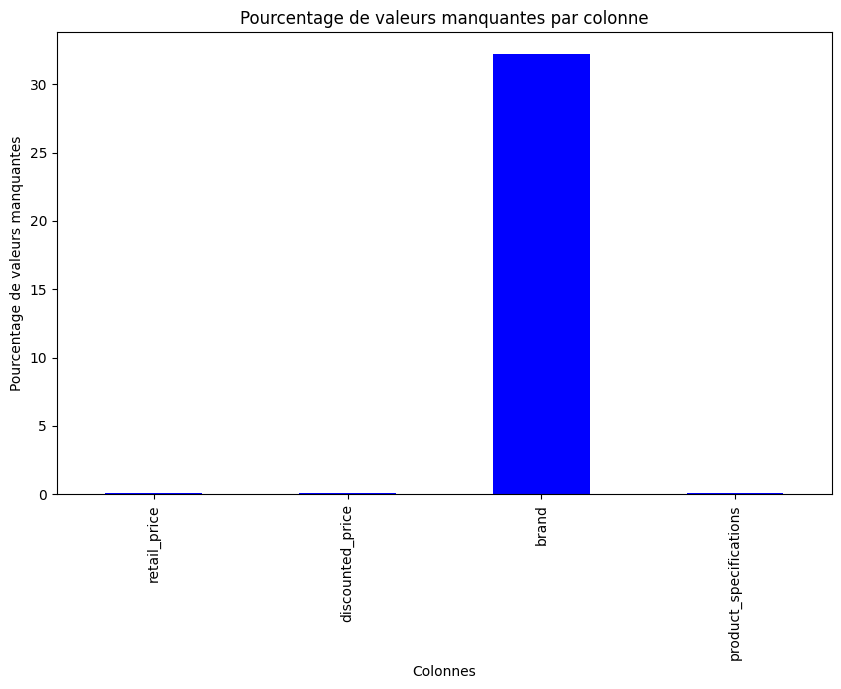

In [ ]:
# Création du bar plot pour les valeurs manquantes
plt.figure(figsize=(10,6))
missing_values_percent.plot(kind='bar', color='blue')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.show()

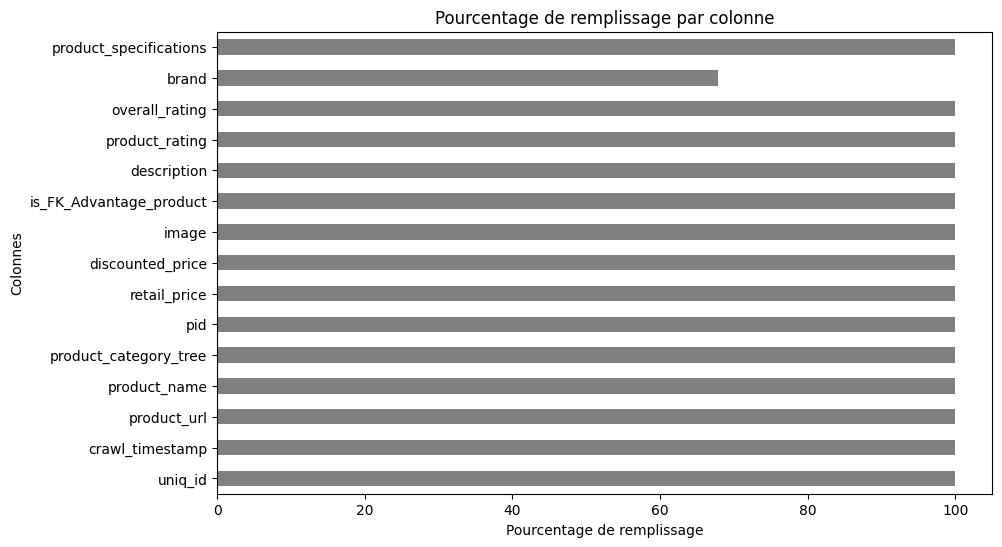

In [ ]:
# Calculer le pourcentage de remplissage pour chaque colonne
filled_values_percent = (1 - df.isnull().sum() / len(df)) * 100

# Création du bar plot horizontal pour le taux de remplissage
plt.figure(figsize=(10,6))
filled_values_percent.plot(kind='barh', color='grey')
plt.title('Pourcentage de remplissage par colonne')
plt.xlabel('Pourcentage de remplissage')
plt.ylabel('Colonnes')
plt.show()

#### <font color='purple'>Exploration des catégories</font>

In [ ]:
# Afficher les colonnes du DataFrame
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

- Les colonnes pertinentes pour notre problématique sont product_name, product_category_tree et description.

In [ ]:
# Appliquer la fonction à la colonne 'product_category_tree' et créer un nouveau DataFrame avec les niveaux de catégories
categories_df = df['product_category_tree'].apply(split_categories)

# Ajouter ce DataFrame au DataFrame d'origine
df_categories = pd.concat([df, categories_df], axis=1)

# Afficher les 10 premières lignes pour voir le résultat
df_categories.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,NaN,NaN,NaN
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",NaN,NaN
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,NaN,NaN
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,NaN,NaN
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,NaN,NaN
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,...,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,Wrist Watches,Maserati Time Wrist Watches,NaN,NaN,NaN,NaN
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,...,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,Wrist Watches,Camerii Wrist Watches,NaN,NaN,NaN,NaN
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,...,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,Wrist Watches,T STAR Wrist Watches,NaN,NaN,NaN,NaN
8,41384da51732c0

- On observe qu'il y a 7 niveaux de catégories.

In [ ]:
# Afficher les valeurs manquantes pour les colonnes de catégories
missing_values_categories = df_categories[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7']].isnull().sum()

# Afficher les résultats
print(missing_values_categories)

cat_1      0
cat_2      0
cat_3      3
cat_4    371
cat_5    645
cat_6    923
cat_7    993
dtype: int64


##### <b>Observations</b>

- cat_1 et cat_2 n'ont aucune valeur manquante.
- À partir de cat_3, il y a progressivement plus de valeurs manquantes, ce qui est attendu, car certains produits n'ont pas autant de niveaux de sous-catégories.

On va donc se concentrer sur cat_1; voici pourquoi:
- Simplicité et clarté : En se concentrant sur la catégorie principale, on simplifie le problème. Les catégories trop profondes (cat_3 et plus) sont souvent très spécifiques, ce qui peut rendre la classification plus difficile sans forcément améliorer les résultats.

- Réduction des valeurs manquantes : Comme il n'y a pas de valeurs manquantes dans cat_1, on élimine directement le besoin de gérer les valeurs manquantes, ce qui rend le modèle plus propre et plus robuste.

- Nombre suffisant de catégories : Le niveau principal de la hiérarchie est souvent suffisant pour classer les produits avec précision, car il regroupe les produits dans des catégories assez générales et compréhensibles.

In [ ]:
# Ne garder que les colonnes 'cat_1' et 'cat_2' pour la classification
df_classification = df_categories[['cat_1', 'product_name', 'description', 'image']]

# Vérifier les premières lignes du nouveau DataFrame
df_classification.head()

,cat_1,product_name,description,image
0,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [ ]:
# Vérifier les catégories uniques du 1er niveau de catégories
categories = df_classification['cat_1'].value_counts()
print(categories)

cat_1
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


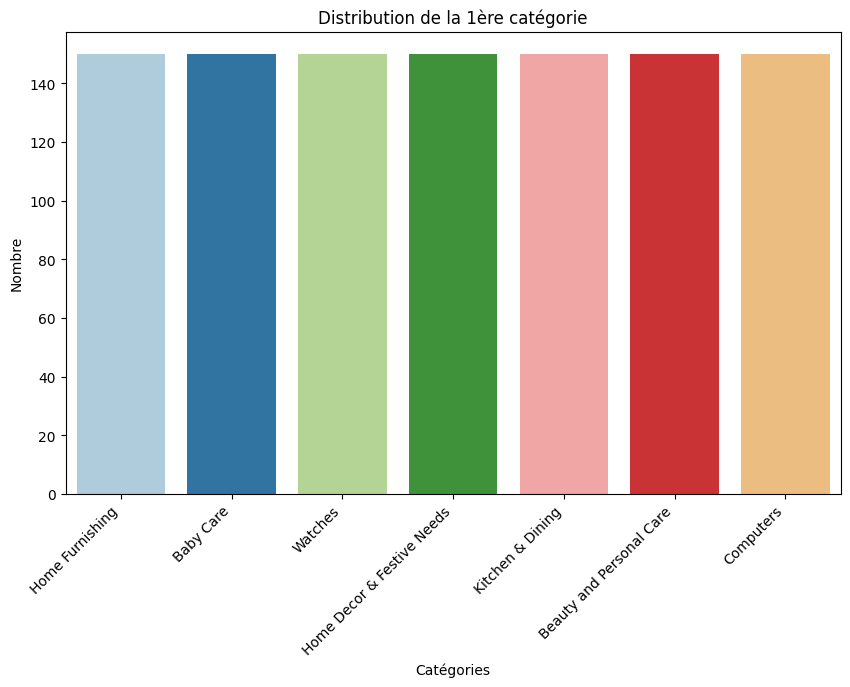

In [ ]:
plot_bar_chart(df_classification, 'cat_1', title="Distribution de la 1ère catégorie")

In [ ]:
# Concaténer 'product_name' et 'description' dans une nouvelle colonne 'combined_text'
df_classification.loc[:, 'combined_text'] = df_classification['product_name'] + ' ' + df_classification['description']

<ipython-input-26-baaea5310365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classification.loc[:, 'combined_text'] = df_classification['product_name'] + ' ' + df_classification['description']


In [ ]:
df_classification.head(5)

,cat_1,product_name,description,image,combined_text
0,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Elegance Polyester Multicolor Abstract Eyelet ...
1,Baby Care,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Sathiyas Cotton Bath Towel Specifications of S...
2,Baby Care,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Eurospa Cotton Terry Face Towel Set Key Featur...
3,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Jaipur Print Cotton Floral King sized Double B...


In [ ]:
# Exporter le data frame dans un fichier CSV.
df_classification.to_csv('/content/drive/My Drive/projet_6/df_classification.csv', index=False, encoding='utf-8')

#### <font color='purple'>Affichage d'exemples d'images</font>

In [ ]:
# Définir le chemin de base des images
image_base_path = '/content/drive/My Drive/projet_6/Images/'

# Créer le chemin complet pour chaque image
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_base_path, x))

# Vérifier que la colonne 'image_path' a bien été créée
print(df[['image', 'image_path']].head())

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                          image_path  
0  /content/drive/My Drive/projet_6/Images/55b85e...  
1  /content/drive/My Drive/projet_6/Images/7b72c9...  
2  /content/drive/My Drive/projet_6/Images/64d5d4...  
3  /content/drive/My Drive/projet_6/Images/d4684d...  
4  /content/drive/My Drive/projet_6/Images/6325b6...  


In [ ]:
# Fonction pour afficher 5 images par catégorie sans texte
def afficher_images_par_toutes_categories(df, nb_images=5):
    # Obtenir les catégories uniques
    categories_uniques = df_classification['cat_1'].unique()

    # Boucler sur chaque catégorie
    for categorie in categories_uniques:
        # Filtrer le DataFrame par la catégorie choisie
        df_filtre = df[df_classification['cat_1'] == categorie].head(nb_images)

        # Afficher les images
        fig, axes = plt.subplots(1, nb_images, figsize=(15, 5))
        fig.suptitle(f"Exemples d'images pour la catégorie : {categorie}")

        for i, (index, row) in enumerate(df_filtre.iterrows()):
            try:
                # Charger l'image à partir du chemin local
                img = mpimg.imread(row['image_path'])
                axes[i].imshow(img)
                axes[i].axis('off')  # Ne pas afficher les axes
            except FileNotFoundError:
                axes[i].set_title('Image non trouvée', fontsize=10)
                axes[i].axis('off')

        plt.show()

In [ ]:
# Utilisation de la fonction : afficher 5 images par catégorie
afficher_images_par_toutes_categories(df, nb_images=5)

Output hidden; open in https://colab.research.google.com to view.

## <font color='red'>5. Prétraitement des données textuelles </font><a class="anchor" id="partie5"></a>

### <font color='blue'>5.1 Nettoyage des données</font><a class="anchor" id="partie5.1">

In [ ]:
# Définir les stopwords anglais et la ponctuation
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stop_words = stop_words.union(punctuation_set)

# Initialiser le lemmatizer et le stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Créer une copie explicite de df_classification avant de travailler dessus
df_classification_copy = df_classification.copy()

# Appliquer les différentes transformations sur la colonne 'description'
df_classification_copy.loc[:, 'descr_bow'] = df_classification_copy['description'].apply(lambda x: transform_bow(x, stop_words))
df_classification_copy.loc[:, 'descr_bow_lem'] = df_classification_copy['description'].apply(lambda x: transform_bow_lem(x, stop_words))
df_classification_copy.loc[:, 'descr_bow_stem'] = df_classification_copy['description'].apply(lambda x: transform_bow_stem(x, stop_words))

# Appliquer les différentes transformations sur la colonne 'combined_text'
df_classification_copy.loc[:, 'combined_bow'] = df_classification_copy['combined_text'].apply(lambda x: transform_bow(x, stop_words))
df_classification_copy.loc[:, 'combined_bow_lem'] = df_classification_copy['combined_text'].apply(lambda x: transform_bow_lem(x, stop_words))
df_classification_copy.loc[:, 'combined_bow_stem'] = df_classification_copy['combined_text'].apply(lambda x: transform_bow_stem(x, stop_words))

# Vérifier les premières lignes pour chaque transformation
print(df_classification_copy[['descr_bow', 'descr_bow_lem', 'descr_bow_stem']].head(2))
print(df_classification_copy[['combined_bow', 'combined_bow_lem', 'combined_bow_stem']].head(2))

                                           descr_bow  \
0  key features elegance polyester multicolor abs...   
1  specifications sathiyas cotton bath towel 3 ba...   

                                       descr_bow_lem  \
0  key feature elegance polyester multicolor abst...   
1  specification sathiyas cotton bath towel 3 bat...   

                                      descr_bow_stem  
0  key featur eleg polyest multicolor abstract ey...  
1  specif sathiya cotton bath towel 3 bath towel ...  
                                        combined_bow  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specifications sath...   

                                    combined_bow_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  sathiyas cotton bath towel specification sathi...   

                                   combined_bow_stem  
0  eleg polyest multicolor abstract eyelet door c...  
1  sathiya cotton bath towel specif sathiya cotto

In [ ]:
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cat_1          1050 non-null   object
 1   product_name   1050 non-null   object
 2   description    1050 non-null   object
 3   image          1050 non-null   object
 4   combined_text  1050 non-null   object
dtypes: object(5)
memory usage: 41.1+ KB


In [ ]:
# Exporter le DataFrame dans un fichier CSV
df_classification_copy.to_csv('/content/drive/My Drive/projet_6/df_classification_copy.csv', index=False)

### <font color='blue'>5.2 Données textuelles : description</font><a class="anchor" id="partie5.2">

#### <font color='green'>5.2.1 CountVectorizer</font><a class="anchor" id="partie5.2.1">

##### <font color='purple'>Calcul de la tailles des différentes matrices</font>

In [ ]:
# Initialiser le CountVectorizer pour Bag of Words
vectorizer_bow = CountVectorizer()

# Appliquer Bag of Words sur chaque version du texte nettoyé
features_bow = vectorizer_bow.fit_transform(df_classification_copy['descr_bow'])
features_bow_lem = vectorizer_bow.fit_transform(df_classification_copy['descr_bow_lem'])
features_bow_stem = vectorizer_bow.fit_transform(df_classification_copy['descr_bow_stem'])

# Vérifier la taille des matrices Bag of Words
print(f"Taille de la matrice Bag of Words sans lemmatisation : {features_bow.shape}")
print(f"Taille de la matrice Bag of Words avec lemmatisation : {features_bow_lem.shape}")
print(f"Taille de la matrice Bag of Words avec stemming : {features_bow_stem.shape}")

Taille de la matrice Bag of Words sans lemmatisation : (1050, 5969)
Taille de la matrice Bag of Words avec lemmatisation : (1050, 5584)
Taille de la matrice Bag of Words avec stemming : (1050, 5088)


##### <font color='purple'>ACP et analyse de clustering</font>

In [ ]:
# Initialiser le label encoder
label_encoder = LabelEncoder()

# Convertir les catégories réelles en entiers
labels_encoded = label_encoder.fit_transform(df_classification['cat_1'])

Bag of Words sans lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 675
ARI Score : 0.304212686917684


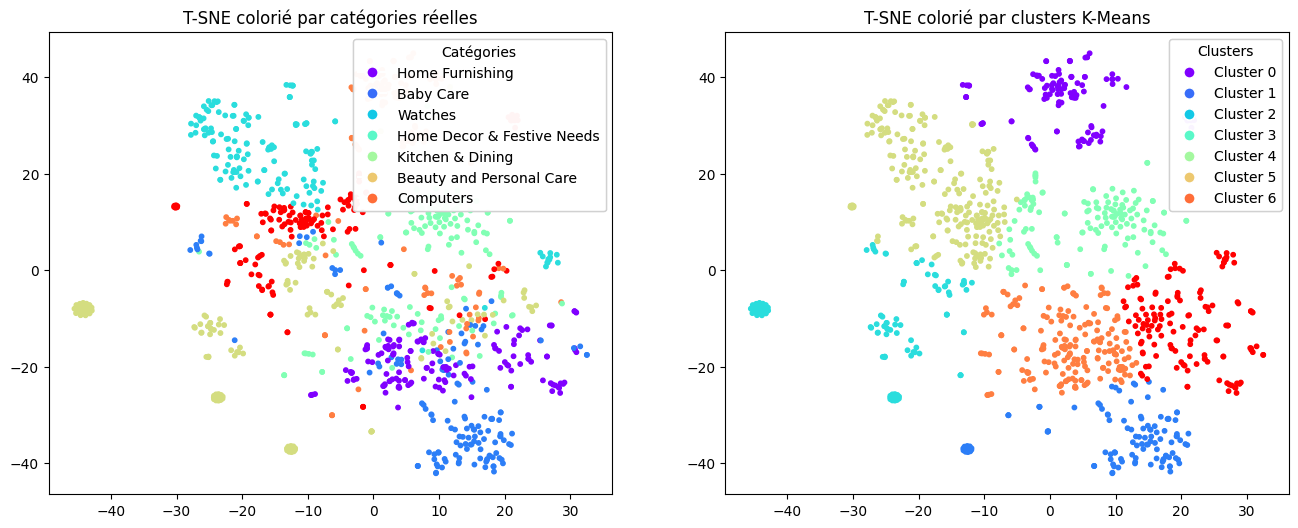

Bag of Words avec lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 665
ARI Score : 0.4131306966608315


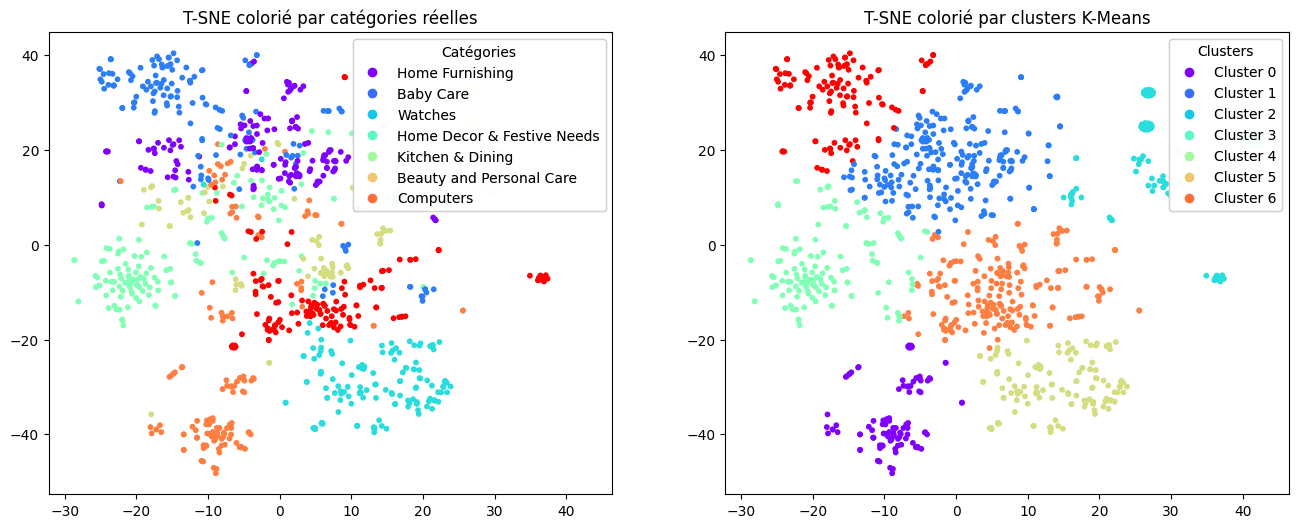

Bag of Words avec stemming
Nombre de composantes pour capturer 99.0% de la variance : 661
ARI Score : 0.39679229058607424


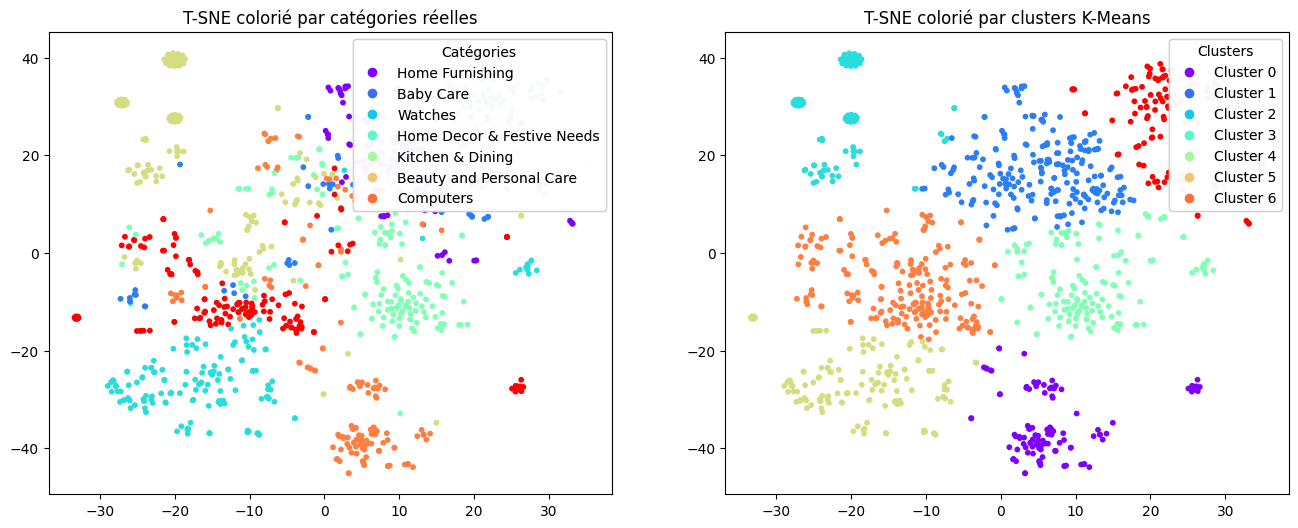

In [ ]:
# Appliquer l'analyse sur les 3 versions des features avec 99% de la variance
print("Bag of Words sans lemmatisation")
analyse_clustering(features_bow, df_classification_copy['cat_1'])

print("Bag of Words avec lemmatisation")
analyse_clustering(features_bow_lem, df_classification_copy['cat_1'])

print("Bag of Words avec stemming")
analyse_clustering(features_bow_stem, df_classification_copy['cat_1'])

#### <font color='green'>5.2.2 Tf-idf</font><a class="anchor" id="partie5.2.2">

##### <font color='purple'>Calcul de la tailles des différentes matrices</font>

In [ ]:
# Fonction pour calculer la matrice TF-IDF
def compute_tfidf(texts, max_features=6000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(texts)

# Calculer la matrice TF-IDF pour chaque version
features_tfidf = compute_tfidf(df_classification_copy['descr_bow'])
features_tfidf_lem = compute_tfidf(df_classification_copy['descr_bow_lem'])
features_tfidf_stem = compute_tfidf(df_classification_copy['descr_bow_stem'])

# Vérifier la taille des matrices Bag of Words
print(f"Taille de la matrice Bag of Words sans lemmatisation : {features_tfidf.shape}")
print(f"Taille de la matrice Bag of Words avec lemmatisation : {features_tfidf_lem.shape}")
print(f"Taille de la matrice Bag of Words avec stemming : {features_tfidf_stem.shape}")

Taille de la matrice Bag of Words sans lemmatisation : (1050, 5969)
Taille de la matrice Bag of Words avec lemmatisation : (1050, 5584)
Taille de la matrice Bag of Words avec stemming : (1050, 5088)


##### <font color='purple'>ACP et analyse de clustering</font>

TF-IDF sans lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 898
ARI Score : 0.3804345325865253


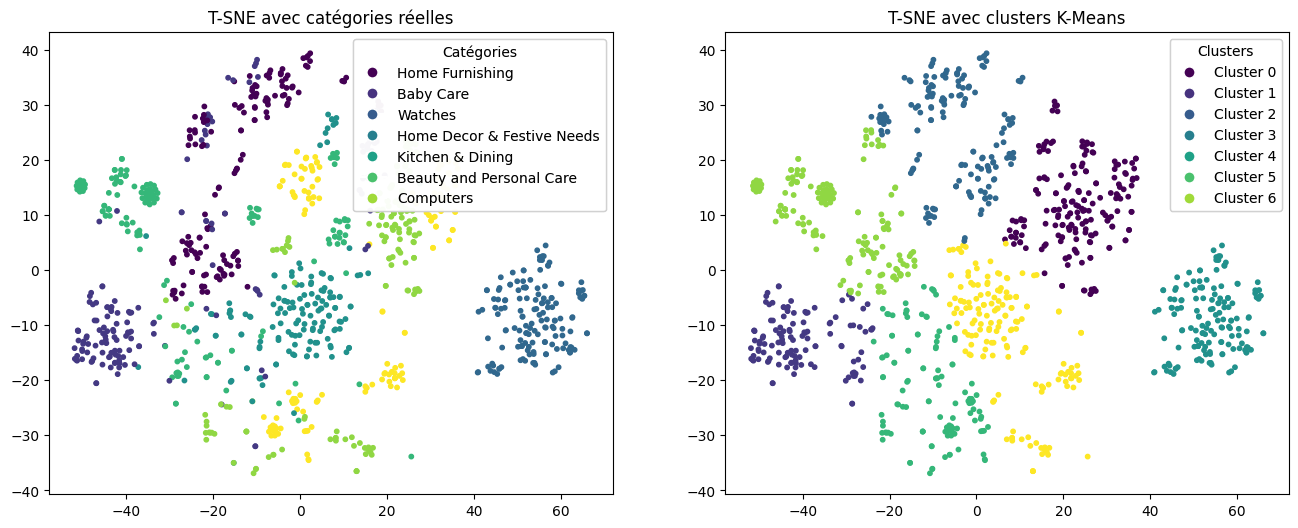

TF-IDF avec lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 895
ARI Score : 0.42429726092949166


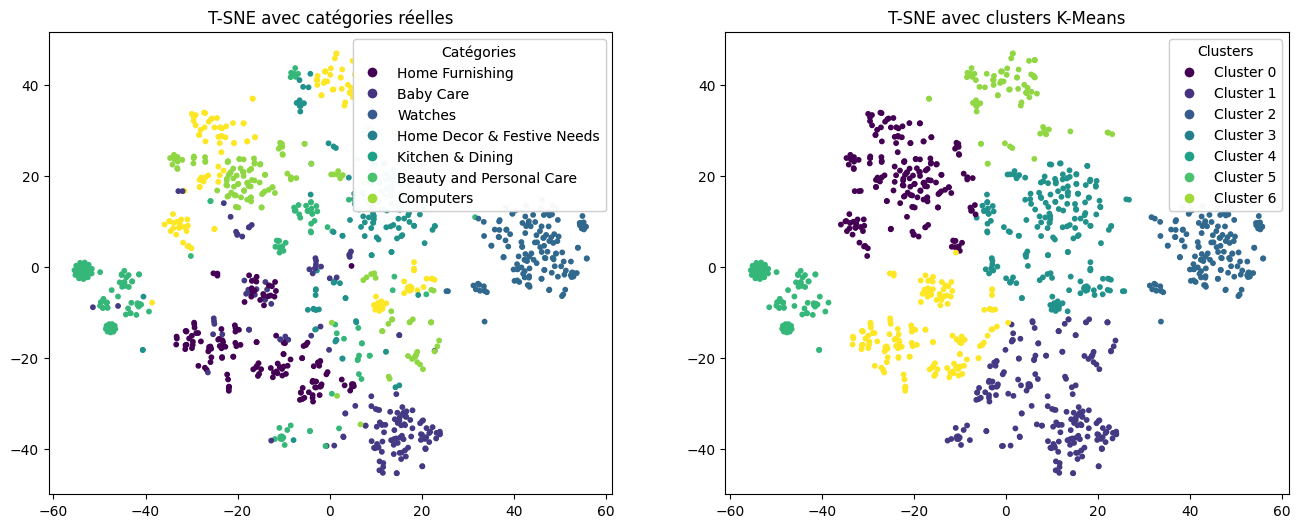

TF-IDF avec stemming
Nombre de composantes pour capturer 99.0% de la variance : 894
ARI Score : 0.38292306631081546


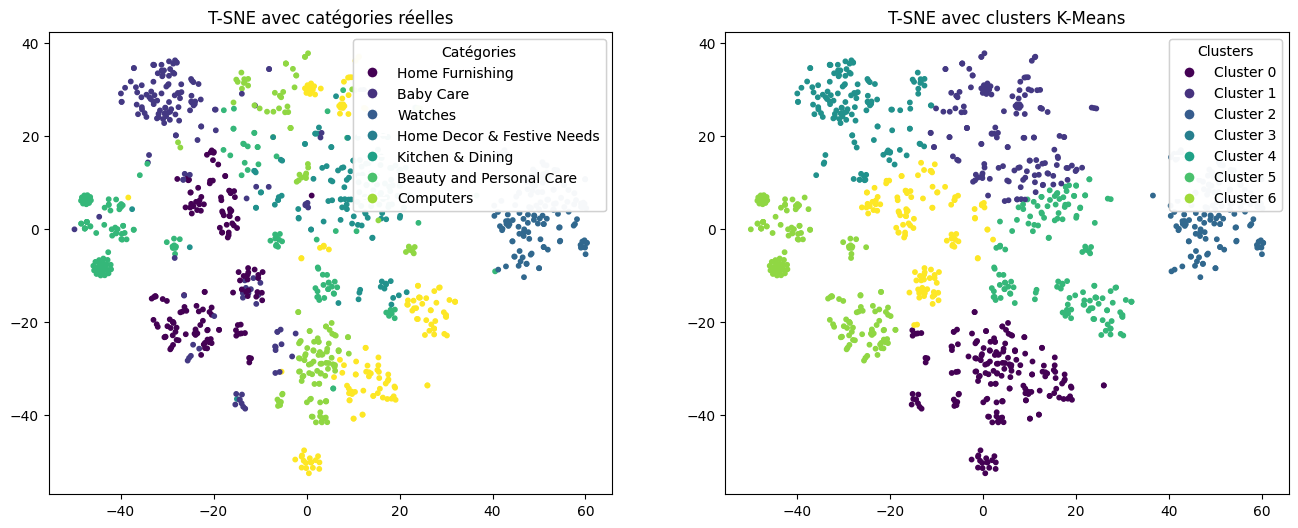

In [ ]:
# Appliquer l'analyse sur TF-IDF sans lemmatisation
print("TF-IDF sans lemmatisation")
analyse_tfidf_clustering(features_tfidf, df_classification_copy['cat_1'])

# Appliquer l'analyse sur TF-IDF avec lemmatisation
print("TF-IDF avec lemmatisation")
analyse_tfidf_clustering(features_tfidf_lem, df_classification_copy['cat_1'])

# Appliquer l'analyse sur TF-IDF avec stemming
print("TF-IDF avec stemming")
analyse_tfidf_clustering(features_tfidf_stem, df_classification_copy['cat_1'])

### <font color='blue'>5.3 Données textuelles : product_name + description</font><a class="anchor" id="partie5.3">

#### <font color='green'>5.3.1 CountVectorizer</font><a class="anchor" id="partie5.3.1">

##### <font color='purple'>Calcul de la tailles des différentes matrices</font>

In [ ]:
# Initialiser le CountVectorizer pour Bag of Words
vectorizer_bow = CountVectorizer()

# Appliquer Bag of Words sur chaque version du texte nettoyé
combine_features_bow = vectorizer_bow.fit_transform(df_classification_copy['combined_bow'])
combine_features_bow_lem = vectorizer_bow.fit_transform(df_classification_copy['combined_bow_lem'])
combine_features_bow_stem = vectorizer_bow.fit_transform(df_classification_copy['combined_bow_stem'])

# Vérifier la taille des matrices Bag of Words
print(f"Taille de la matrice Bag of Words sans lemmatisation : {combine_features_bow.shape}")
print(f"Taille de la matrice Bag of Words avec lemmatisation : {combine_features_bow_lem.shape}")
print(f"Taille de la matrice Bag of Words avec stemming : {combine_features_bow_stem.shape}")

Taille de la matrice Bag of Words sans lemmatisation : (1050, 5969)
Taille de la matrice Bag of Words avec lemmatisation : (1050, 5584)
Taille de la matrice Bag of Words avec stemming : (1050, 5088)


##### <font color='purple'>ACP et analyse de clustering</font>

Bag of Words sans lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 773
ARI Score : 0.3620542516055136


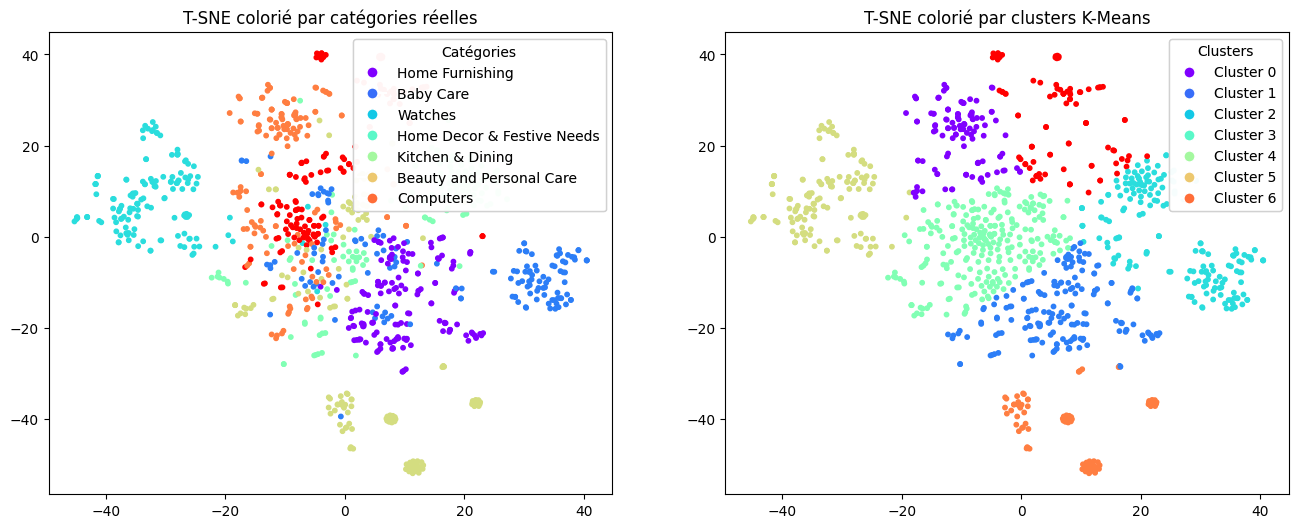

Bag of Words avec lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 764
ARI Score : 0.4204294915094213


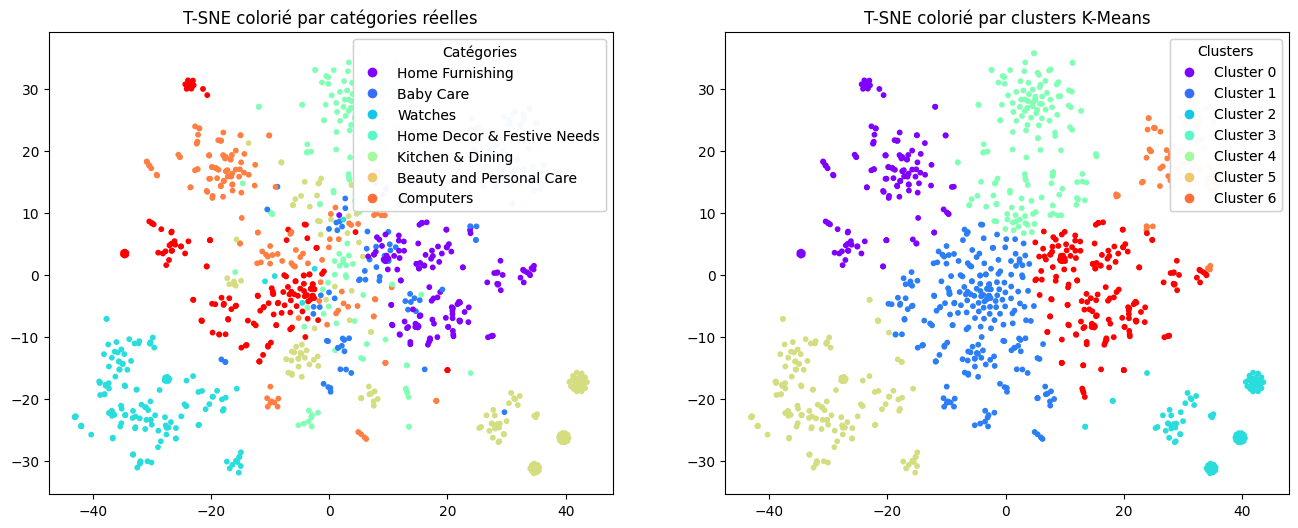

Bag of Words avec stemming
Nombre de composantes pour capturer 99.0% de la variance : 760
ARI Score : 0.3908592213639742


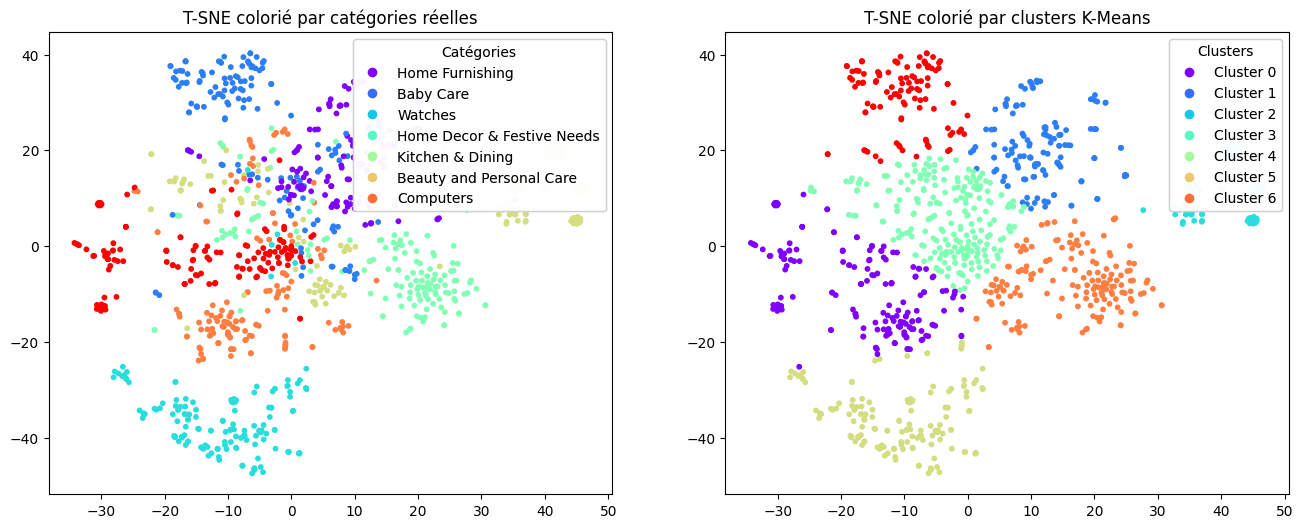

In [ ]:
# Appliquer l'analyse sur les 3 versions des features avec 99% de la variance
print("Bag of Words sans lemmatisation")
analyse_clustering(combine_features_bow, df_classification_copy['cat_1'])

print("Bag of Words avec lemmatisation")
analyse_clustering(combine_features_bow_lem, df_classification_copy['cat_1'])

print("Bag of Words avec stemming")
analyse_clustering(combine_features_bow_stem, df_classification_copy['cat_1'])

#### <font color='green'>5.3.2 Tf-idf</font><a class="anchor" id="partie5.3.2">

##### <font color='purple'>Calcul de la tailles des différentes matrices</font>

In [ ]:
# Fonction pour calculer la matrice TF-IDF en stockant le vectorizer
def compute_tfidf(texts, max_features=6000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    features = vectorizer.fit_transform(texts)
    return features, vectorizer

# Calculer la matrice TF-IDF pour chaque version
combined_feat_tfidf, tfidf_vectorizer = compute_tfidf(df_classification_copy['combined_bow'])
combined_feat_tfidf_lem, tfidf_vectorizer_lem = compute_tfidf(df_classification_copy['combined_bow_lem'])
combined_feat_tfidf_stem, tfidf_vectorizer_stem = compute_tfidf(df_classification_copy['combined_bow_stem'])

# Vérifier la taille des matrices Bag of Words
print(f"Taille de la matrice Bag of Words sans lemmatisation : {combined_feat_tfidf.shape}")
print(f"Taille de la matrice Bag of Words avec lemmatisation : {combined_feat_tfidf_lem.shape}")
print(f"Taille de la matrice Bag of Words avec stemming : {combined_feat_tfidf_stem.shape}")

Taille de la matrice Bag of Words sans lemmatisation : (1050, 5969)
Taille de la matrice Bag of Words avec lemmatisation : (1050, 5584)
Taille de la matrice Bag of Words avec stemming : (1050, 5088)


##### <font color='purple'>ACP et analyse de clustering</font>

TF-IDF sans lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 907
ARI Score : 0.5105174653900125


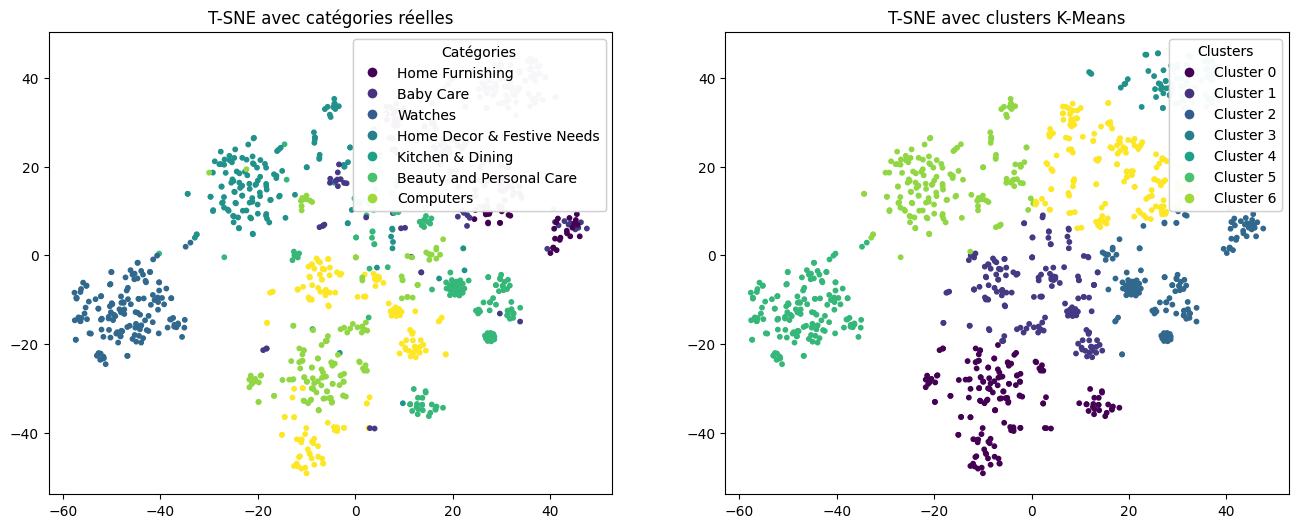

TF-IDF avec lemmatisation
Nombre de composantes pour capturer 99.0% de la variance : 904
ARI Score : 0.4972651825818159


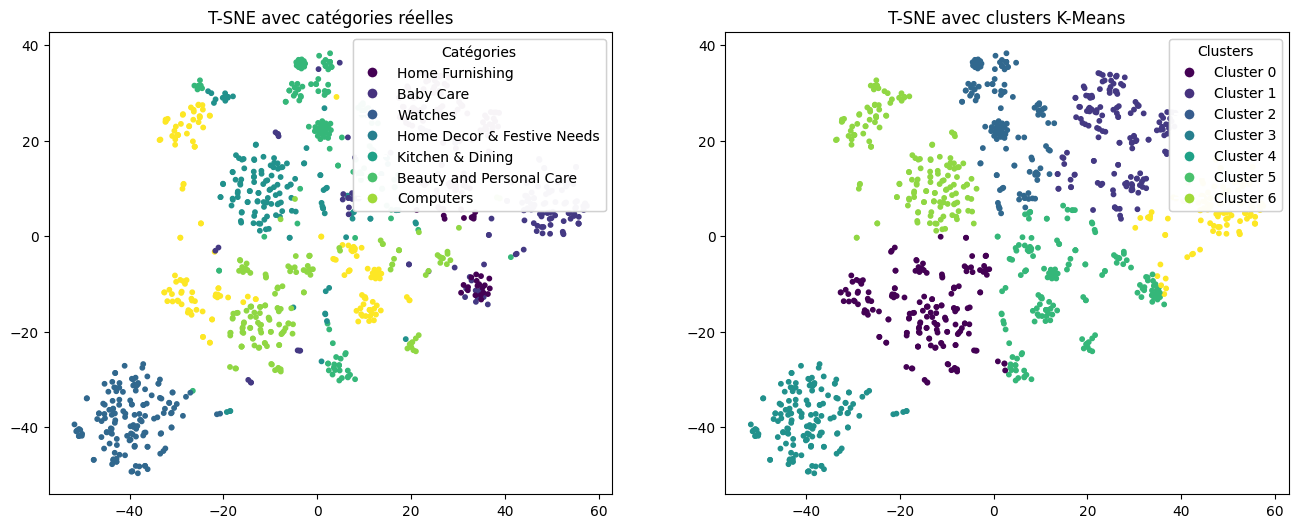

TF-IDF avec stemming
Nombre de composantes pour capturer 99.0% de la variance : 903
ARI Score : 0.489012005780717


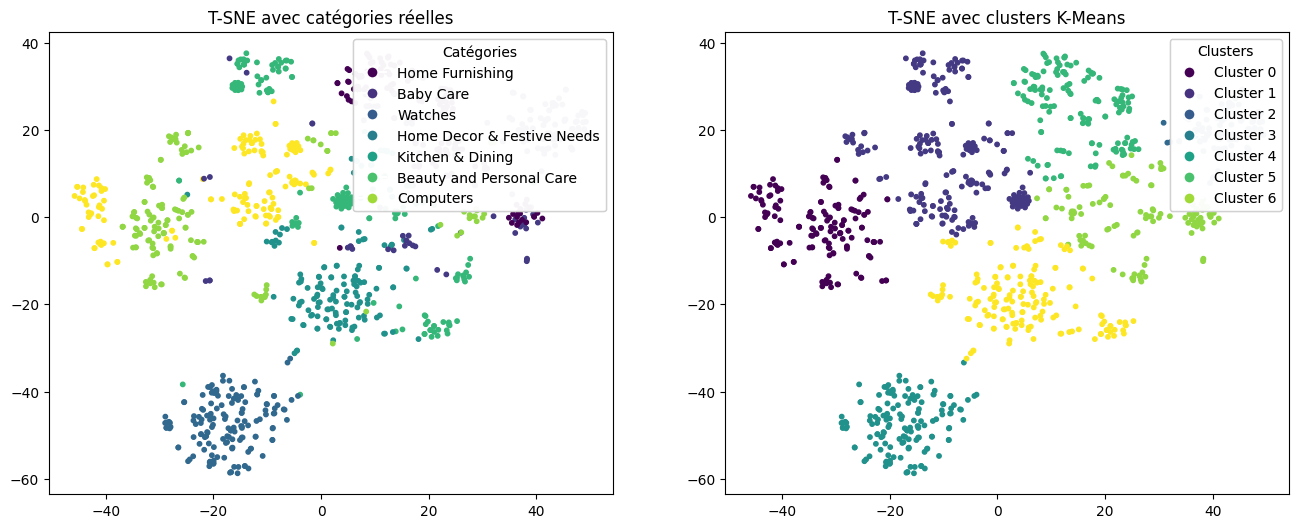

In [ ]:
# Appliquer l'analyse sur TF-IDF sans lemmatisation
print("TF-IDF sans lemmatisation")
analyse_tfidf_clustering(combined_feat_tfidf, df_classification_copy['cat_1'])

# Appliquer l'analyse sur TF-IDF avec lemmatisation
print("TF-IDF avec lemmatisation")
analyse_tfidf_clustering(combined_feat_tfidf_lem, df_classification_copy['cat_1'])

# Appliquer l'analyse sur TF-IDF avec stemming
print("TF-IDF avec stemming")
analyse_tfidf_clustering(combined_feat_tfidf_stem, df_classification_copy['cat_1'])

### <font color='blue'>5.4 Résultats</font><a class="anchor" id="partie5.4">

In [ ]:
# Créer un dictionnaire avec les données
data = {
    'Approche': ['CountVectorizer', 'CountVectorizer', 'CountVectorizer', 'Tf-idf', 'Tf-idf', 'Tf-idf',
                 'CountVectorizer', 'CountVectorizer', 'CountVectorizer', 'Tf-idf', 'Tf-idf', 'Tf-idf'],
    'Nettoyage': ['sans lemmatisation', 'avec lemmatisation', 'avec stemming',
                  'sans lemmatisation', 'avec lemmatisation', 'avec stemming',
                  'sans lemmatisation', 'avec lemmatisation', 'avec stemming',
                  'sans lemmatisation', 'avec lemmatisation', 'avec stemming'],
    'Colonne': ['description', 'description', 'description', 'description', 'description', 'description',
                'description + product_name', 'description + product_name', 'description + product_name',
                'description + product_name', 'description + product_name', 'description + product_name'],
    'Composantes': [675, 665, 661, 898, 895, 894, 773, 764, 760, 907, 904, 903],
    'ARI Score': [0.3448, 0.3989, 0.3807, 0.3804, 0.4243, 0.3829, 0.3719, 0.4436, 0.4089, 0.5105, 0.4973, 0.4890]
}

# Créer un DataFrame à partir du dictionnaire
df_results = pd.DataFrame(data)

# Afficher le tableau
display(df_results)

,Approche,Nettoyage,Colonne,Composantes,ARI Score
0,CountVectorizer,sans lemmatisation,description,675,0.3448
1,CountVectorizer,avec lemmatisation,description,665,0.3989
2,CountVectorizer,avec stemming,description,661,0.3807
3,Tf-idf,sans lemmatisation,description,898,0.3804
4,Tf-idf,avec lemmatisation,description,895,0.4243
5,Tf-idf,avec stemming,description,894,0.3829
6,CountVectorizer,sans lemmatisation,description + product_name,773,0.3719
7,CountVectorizer,avec lemmatisation,description + product_name,764,0.4436
8,CountVectorizer,avec stemming,description + product_name,760,0.4089
9,Tf-idf,sans lemmatisation,description + product_name,907,0.5105


#### <font color='purple'>Observations</font>

- D'après les résultats, l'approche Tf-idf donne de meilleurs scores ARI, notamment avec la combinaison description + product_name et le nettoyage avec ou sans lemmatisation. Le meilleur score atteint est 0.5105 avec Tf-idf sans lemmatisation pour la colonne description + product_name.

- Cela indique que Tf-idf est plus performant que CountVectorizer dans notre cas pour capturer la structure des données textuelles et produire des clusters plus cohérents avec les catégories réelles. La combinaison des colonnes description et product_name a également amélioré les performances globales.

### <font color='blue'>5.5 LDA : </font><a class="anchor" id="partie5.4">

In [ ]:
# Appliquer LDA sur la meilleure transformation Tf-idf (sans lemmatisation)
appliquer_lda(combined_feat_tfidf, tfidf_vectorizer)

Thème 0:  set combo com flipkart cash genuine shipping delivery free products
Thème 1:  watch analog baby cotton men girl women towel dress sonata
Thème 2:  cell battery laptop hp pavilion lapguard replacement guarantee 30 buy
Thème 3:  abstract blanket single double prithish mugs mug products multicolor buy
Thème 4:  cm polyester eyelet curtain laptop showpiece inch door bedsheet print
Thème 5:  mug ceramic rockmantra features specifications product details material baby warranty
Thème 6:  mug coffee printland ceramic tea nutcase one bottle showpiece gift


LatentDirichletAllocation(n_components=7, random_state=42)

#### <font color='purple'>Observations</font>

Voici les correspondances entre les thèmes extraits par LDA et les catégories principales, rangées par thème :

- Thème 0 :
  - Mots dominants : set, combo, flipkart, cash, genuine, shipping, delivery, free, products
  - Aucune correspondance claire avec une catégorie spécifique. Ce thème semble plutôt général et pourrait correspondre à des offres, promotions ou descriptions logistiques.

- Thème 1 :
  - Mots dominants : watch, analog, baby, cotton, men, girl, women, towel, dress, sonata
  - Watches : Les mots watch et analog se réfèrent directement à cette catégorie.
  - Baby Care : Les mots baby, cotton, et towel évoquent des articles pour bébé.
  - Beauty and Personal Care (indirectement) : Les produits comme towel et cotton pourraient être liés aux soins personnels.

- Thème 2 :
  - Mots dominants : cell, battery, laptop, hp, pavilion, lapguard, replacement, guarantee, buy
  - Computers : Ce thème correspond directement aux ordinateurs et accessoires (batteries, laptops).

- Thème 3 :
  - Mots dominants : abstract, blanket, single, double, prithish, mugs, mug, products, multicolor, buy
  - Home Furnishing : Les mots blanket, single, double, et multicolor correspondent à des articles de literie ou de décoration de la maison.

- Thème 4 :
  - Mots dominants : cm, polyester, eyelet, curtain, laptop, showpiece, inch, door, bedsheet, print
  - Home Furnishing : Les mots curtain, door, bedsheet sont directement liés aux articles d'ameublement et de décoration intérieure.
  - Home Decor & Festive Needs : Le mot showpiece fait référence à des articles décoratifs, ce qui correspond à cette catégorie.

- Thème 5 :
  - Mots dominants : mug, ceramic, rockmantra, features, specifications, product, details, material, baby, warranty
  - Kitchen & Dining : Le mot mug et d'autres termes liés à des articles de cuisine comme ceramic indiquent un lien avec cette catégorie.
  - Home Decor & Festive Needs : Certains termes comme showpiece ou gift peuvent être liés à cette catégorie.

- Thème 6 :
  - Mots dominants : mug, coffee, printland, ceramic, tea, nutcase, one, bottle, showpiece, gift
  - Kitchen & Dining : Les mots mug, coffee, tea, et bottle sont fortement liés à cette catégorie.
  - Home Decor & Festive Needs : Le mot showpiece suggère des articles décoratifs, et gift est également lié à des objets de décoration ou de cadeaux.

Ces correspondances ne sont pas parfaites, mais elles montrent que les thèmes extraits par LDA capturent des regroupements cohérents par rapport aux catégories principales.

## <font color='red'>6. Conclusion</font><a class="anchor" id="partie6"></a>

L'objectif de cette partie était de vérifier la faisabilité d'une classification automatique des produits à partir de leurs descriptions textuelles. Plusieurs étapes ont été suivies pour répondre à cette question, incluant un nettoyage des données, l'extraction de features textuelles via différentes approches (Bag-of-Words et TF-IDF), une réduction de dimension via ACP et T-SNE, et enfin une analyse de clustering avec K-Means.

1. Séparation des catégories :
   - Les visualisations obtenues avec T-SNE montrent que les produits sont relativement bien séparés en fonction de leurs catégories réelles. Bien que certaines catégories soient plus distinctes que d'autres, les clusters produits par l'algorithme de K-Means se rapprochent des catégories réelles, comme l'indiquent les ARI scores.

  - Les meilleurs scores obtenus avec l'approche TF-IDF, en particulier TF-IDF sans lemmatisation appliqué sur la combinaison de product_name et description, ont atteint un ARI score de 0.51, ce qui est un bon indicateur de la faisabilité de la séparation automatique des produits par catégories.

2. Impact du prétraitement :
  - Les résultats montrent que l'inclusion de la colonne product_name en plus de description a amélioré la performance des modèles, en particulier avec l'approche TF-IDF. Cela suggère que les noms de produits contiennent des informations cruciales qui permettent de mieux distinguer les catégories.

  - Les différentes approches de prétraitement (lemmatisation, stemming) ont montré des variations dans les résultats, mais l'approche sans lemmatisation a fourni les meilleures performances globales.

3. Faisabilité de la classification automatique :
  - Les résultats globaux confirment la faisabilité de classer automatiquement les produits en utilisant leurs descriptions textuelles et noms de produits. Bien que l'ARI score optimal (0.51) ne soit pas parfait, il est dans la fourchette attendue pour ce type d'analyse (0.4 à 0.5), confirmant qu'il est possible d'obtenir une séparation visuelle et quantitative raisonnable des produits par catégorie.

4. Limitations et perspectives :
  - Il est à noter que certaines catégories se chevauchent plus que d'autres, notamment les produits avec des descriptions génériques ou des noms peu distinctifs. Une amélioration pourrait être envisagée en affinant le prétraitement ou en utilisant des modèles plus sophistiqués comme des modèles de type BERT pour mieux capturer les nuances des descriptions.

  - Enfin, l'analyse des thèmes avec LDA a également permis de voir des regroupements logiques des produits dans les clusters, bien que la correspondance avec les catégories réelles reste parfois vague, en raison de la variabilité des descriptions textuelles.


En conclusion, ce projet a montré que la classification automatique des produits par description textuelle est non seulement faisable mais produit également des résultats visuellement et numériquement cohérents. L'approche TF-IDF combinée à l'analyse K-Means et T-SNE a démontré une séparation des catégories satisfaisante, avec des résultats qui pourraient être affinés avec des modèles plus sophistiqués pour améliorer davantage les performances.